In [311]:
import torch
import torch.nn as nn
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np

In [312]:
pd.read_csv("/home/ikrfun/Projects/practice_lstm/data/random_sin.csv")

Unnamed: 0      rand_y
0              0  124.659615
1              1  203.076973
2              2  150.163264
3              3  183.287781
4              4  195.836287
...          ...         ...
1495        1495   32.712558
1496        1496  157.361816
1497        1497  -42.031427
1498        1498  -42.840567
1499        1499   68.186476

[1500 rows x 2 columns]

In [313]:
class LSTM(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = 1, hidden_size = self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self,x):
        x,_ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)
        return x

In [314]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [315]:
class make_datasets:#データの前処理を行えるクラス
    def __init__(self,csv_file,col_name, type, num_window=0):
        raw_data = pd.read_csv(csv_file)
        self.price = raw_data[col_name]
        #self.date = raw_data["date"]
        self.seq_arr = []
        self.target_arr = []
        self.seq_train = []
        self.target_train = []
        self.seq_test = []
        self.target_test = []
        if type == "lstm":
            self.make_data_for_lstm(num_window)
        elif type == "mlp":
            self.make_data_for_mlp()
        else:
            print("type:{}は存在しません".format(type))
        
    def make_data_for_lstm(self, num_window): #LSTMのためのデータセットを作成する
        num_data = len(self.price)
        seq_data = []
        target_data = []
        for i in range(num_data - num_window):
            seq_data.append(self.price[i:i+num_window])
            target_data.append(self.price[i+num_window:1+i+num_window])
        self.seq_arr = np.array(seq_data)
        self.target_arr = np.array(target_data)
    
    def make_data_for_mlp(self):
        pass#今後実装
    
    def lstm_train_data(self,num_test):
        self.seq_train = FloatTensor(self.seq_arr[:-num_test].astype(np.float32))
        self.target_train = FloatTensor(self.target_arr[:-num_test].astype(np.float32))
        self.seq_test = FloatTensor(self.seq_arr[-num_test :].astype(np.float32))
        self.target_test = FloatTensor(self.target_arr[-num_test :].astype(np.float32))
        return self.seq_train, self.target_train, self.seq_test, self.target_test

In [316]:
dataset = make_datasets("/home/ikrfun/Projects/practice_lstm/data/random_sin.csv",type="lstm",col_name = "rand_y",num_window = 10)

In [317]:
seq_train_t, target_train_t, seq_test_t, target_test_t = dataset.lstm_train_data(300)
print(type(seq_train_t), type(target_train_t))



<class 'torch.Tensor'> <class 'torch.Tensor'>


In [318]:
seq_train_t = seq_train_t.permute(1,0) #次元の入れ替え
target_train_t= target_train_t.permute(1,0) 
seq_train_t = seq_train_t.unsqueeze(dim = -1) #３次元にする
target_train_t = target_train_t.unsqueeze(dim = -1)
criterion = nn.MSELoss()
num_hidden = 100 #モデルのLSTMブロックの数を定義
lr = 0.01 #ラーニングレートを設定
num_epoch = 1000
model = LSTM(num_hidden)
optimizer = optim.Adam(model.parameters(),lr = lr)

In [319]:
print(seq_train_t.size(),target_train_t.size())
x_d = seq_train_t.to(device)
y_d = target_train_t.to(device)

torch.Size([10, 1190, 1]) torch.Size([1, 1190, 1])


In [320]:
def learn(x,y,num_epoch):
    model.train()
    losses = []
    for epoch in range(num_epoch):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if epoch % 100 == 0:
            print("epoch{} : loss{}".format(epoch,loss.item()))
        plt.plot(losses)

epoch0 : loss48262.05859375
/home/ikrfun/anaconda3/envs/torch_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1190, 1])) that is different to the input size (torch.Size([1190, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch100 : loss26652.416015625
epoch200 : loss15076.208984375
epoch300 : loss8650.0234375
epoch400 : loss5524.93701171875
epoch500 : loss3672.016845703125
epoch600 : loss2804.164794921875
epoch700 : loss2326.49951171875
epoch800 : loss2718.043701171875
epoch900 : loss2298.41845703125


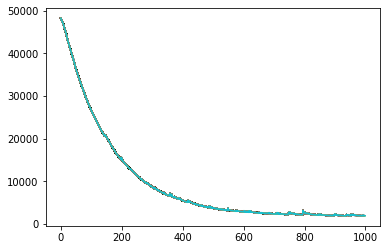

In [321]:
model.to(device)
learn(x_d,y_d,num_epoch)

In [322]:
def run_test(data):
    model.eval()
    data= data.permute(1,0)
    data = data.unsqueeze(dim = -1)
    data = data.to(device)
    y_pred = model(data)
    y_pred = y_pred.to("cpu")
    y_pred = y_pred.detach().numpy()
    plt.plot(y_pred)

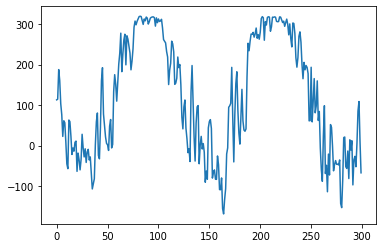

In [323]:
run_test(seq_test_t)

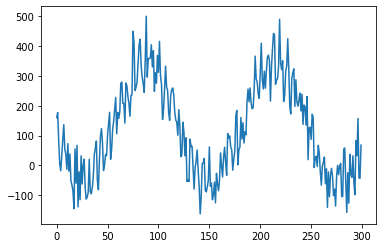

In [324]:
plt.plot(target_test_t.detach().numpy())